In [135]:
# import all the E9 stuff
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# User defined modules
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
import E9_fn.E9_constants as E9c
import E9_fn.E9_atom as E9a
import E9_fn.E9_cooltrap as E9ct
import E9_fn.polarizabilities_calculation as E9pol
# import E9_fn.datasets.transition_line_data as TLData
from E9_fn import util

# Logging
logpath = '' # '' if not logging to a file
loglevel = logging.INFO
logroot = logging.getLogger()
list(map(logroot.removeHandler, logroot.handlers))
list(map(logroot.removeFilter, logroot.filters))
logging.basicConfig(filename = logpath, level = loglevel)

# Atom stuff

In [136]:
Rb_atom = E9a.Rb87_5_2S1o2_F2
mu_Rb = E9c.mu_B * Rb_atom.gF * 2   # 2 here is mF = 2; sign is V = mu * B
K_atom = E9a.K40_4_2S1o2_F9o2
mu_K = E9c.mu_B * K_atom.gF * 9/2

# Trap geometries

In [137]:
spatial_resolution = 0.5e-6
xmin, xmax = -150 * 1e-6, 150 * 1e-6
ymin, ymax = -150 * 1e-6, 150 * 1e-6
zmin, zmax = -100 * 1e-6, 100 * 1e-6
include_gravity = True

In [138]:
x_range_trap = np.linspace(xmin, xmax, int((xmax - xmin) // spatial_resolution))
y_range_trap = np.linspace(ymin, ymax, int((ymax - ymin) // spatial_resolution))
z_range_trap = np.linspace(zmin, zmax, int((zmax - zmin) // spatial_resolution))
x0_index = abs(x_range_trap).argmin()
y0_index = abs(y_range_trap).argmin()
z0_index = abs(z_range_trap).argmin()
V_voxel = spatial_resolution ** 3

## Magnetic trap

### Inputs

In [139]:
B_grad_xy = 50. / 100   # Magnetic field gradient in the xy-plane (lattice plane), in [G/cm] / 100 (-> [T/m])

In [140]:
B_grad_z = 2 * B_grad_xy

## Plug beam parameters

### Inputs

In [141]:
w0_plug = 35e-6         # Beam waist (1/e^2 radius) of the plug beam
lambda_plug = 532e-9    # wavelength of the plug beam
pwr_plug = 2          # Optical power in the plug beam
plug_direction = "y"    # Optical axis of the plug beam; "y" for lattice plane, or "z" for gravity direction
delta_x = 5e-6         # Displacement of the beam from the B trap center in the x direction
delta_z = 0e-6          # Displacement of the beam from the B trap center in the z direction

In [142]:
Rb_pol = E9pol.alpha_s_Rb_5S1o2(lambda_plug)
K_pol = E9pol.alpha_s_K_4S1o2(lambda_plug)

I_plug_max = util.I_from_power(pwr_plug, w0_plug)
V_uK_Rb_plug = E9pol.I2uK_from_pol(I_plug_max, Rb_pol)
V_uK_K_plug = E9pol.I2uK_from_pol(I_plug_max, K_pol)
print(f"(Anti-)trap depth of the plug beam for Rb: {V_uK_Rb_plug}")
print(f"(Anti-)trap depth of the plug beam for K: {V_uK_K_plug}")

INFO:root:K_4S1o2_3D5o2 transition does not have f_ik data (not E1 allowed?)
INFO:root:K_4S1o2_3D5o2 transition does not have f_ik data (not E1 allowed?)
INFO:root:K_4S1o2_4D5o2 transition does not have f_ik data (not E1 allowed?)
INFO:root:K_4S1o2_4D3o2 transition does not have f_ik data (not E1 allowed?)


(Anti-)trap depth of the plug beam for Rb: 61.213004338309766
(Anti-)trap depth of the plug beam for K: 60.80122638357856


In [143]:
fig_title_trap_params = (r"$B'_x =$" f"{B_grad_xy * 100:.1f} G/cm, "
                         r"$\lambda_{plug} =$" f"{lambda_plug * 1e9:.0f} nm, "
                         r"$I_{plug} =$" f"{pwr_plug} W, "
                         r"$w_{plug} = $" f"{w0_plug * 1e6:.0f} um, "
                         r"$(\Delta_x, \Delta_z) =$" f"({delta_x * 1e6:.0f}, {delta_z * 1e6:.0f}) um")

# Combined trap parameters

### Effective trap frequencies from the Na BEC paper

In [144]:
if plug_direction == "y":
    y_Vmin_Rb = 0.
    y_Vmin_K = 0.
if plug_direction == "z":
    raise NotImplementedError("Not done yet")

# Plot the combined trapping potential for the xz and xy plane
xx_xz, zz_xz = np.meshgrid(x_range_trap, z_range_trap)          # The coordinates are in (z, x)
r_xz = np.sqrt((xx_xz - delta_x)**2 + (zz_xz - delta_z)**2)
xx_xy, yy_xy = np.meshgrid(x_range_trap, y_range_trap)          # The coordinates are in (y, x)
r_xy = np.sqrt((xx_xy - delta_x)**2 + yy_xy**2)

V_uK_Rb_B_xz = mu_Rb * np.sqrt(xx_xz**2 + 4 * zz_xz**2) * B_grad_xy / E9c.k_B / 1e-6
V_uK_Rb_B_xy = mu_Rb * np.sqrt(xx_xy**2 + yy_xy**2) * B_grad_xy / E9c.k_B / 1e-6
V_uK_Rb_plug_xz = V_uK_Rb_plug * util.I_gaussian_beam_3D(r_xz, 0., w0_plug, lambda_plug)
V_uK_Rb_plug_xy = V_uK_Rb_plug * util.I_gaussian_beam_3D(r_xy, yy_xy, w0_plug, lambda_plug)
V_uK_Rb_grav = int(include_gravity) * E9c.m_Rb87 * E9c.g_earth * zz_xz / E9c.k_B / 1e-6
V_uK_Rb_tot_xz = V_uK_Rb_B_xz + V_uK_Rb_plug_xz + V_uK_Rb_grav
V_uK_Rb_tot_xy = V_uK_Rb_B_xy + V_uK_Rb_plug_xy

V_uK_K_B_xz = mu_K * np.sqrt(xx_xz**2 + 4 * zz_xz**2) * B_grad_xy / E9c.k_B / 1e-6
V_uK_K_B_xy = mu_K * np.sqrt(xx_xy**2 + yy_xy**2) * B_grad_xy / E9c.k_B / 1e-6
V_uK_K_plug_xz = V_uK_K_plug * util.I_gaussian_beam_3D(r_xz, 0., w0_plug, lambda_plug)
V_uK_K_plug_xy = V_uK_K_plug * util.I_gaussian_beam_3D(r_xy, yy_xy, w0_plug, lambda_plug)
V_uK_K_grav = int(include_gravity) * E9c.m_K40 * E9c.g_earth * zz_xz / E9c.k_B / 1e-6
V_uK_K_tot_xz = V_uK_K_B_xz + V_uK_K_plug_xz + V_uK_K_grav
V_uK_K_tot_xy = V_uK_K_B_xy + V_uK_K_plug_xy

# Find the position of trap minimum
if not np.isclose(delta_z, 0):
    logging.warning(f"The formulae for effective trap frequencies are only valid for delta_z = 0, but delta_z = {delta_z}")
if include_gravity:
    logging.warning(f"The formulae for effective trap frequencies doesn't include gravity")
    logging.warning(f"Including gravity changes the position of trap minimum found numerically")

Vmin_arg_Rb = V_uK_Rb_tot_xz.argmin()
Vmin_arg_K = V_uK_K_tot_xz.argmin()
x_Vmin_Rb = xx_xz.flatten()[Vmin_arg_Rb]
x_Vmin_K = xx_xz.flatten()[Vmin_arg_K]
z_Vmin_Rb = zz_xz.flatten()[Vmin_arg_Rb]
z_Vmin_K = zz_xz.flatten()[Vmin_arg_K]
x_Vmin_offset = abs(x_Vmin_Rb - x_Vmin_K)
y_Vmin_offset = abs(y_Vmin_Rb - y_Vmin_K)
z_Vmin_offset = abs(z_Vmin_Rb - z_Vmin_K)
print(f"B trap parameters: B_grad_z = {B_grad_z * 100} G/cm")
print(f"Plug beam parameters: lambda = {lambda_plug * 1e9} nm, I = {pwr_plug} W, waist = {w0_plug * 1e6} um, center at (x, z) = ({delta_x * 1e6}, {delta_z * 1e6}) um")
print(f"trap minimum of Rb is at (x, z) = ({x_Vmin_Rb * 1e6:.2f}, {z_Vmin_Rb * 1e6:.2f}) um")
print(f"trap minimum of K is at (x, z) = ({x_Vmin_K * 1e6:.2f}, {z_Vmin_K * 1e6:.2f}) um")

# Effective trap frequencies from the Na BEC paper
w_PQy_Rb = np.sqrt(mu_Rb * B_grad_z / (2 * E9c.m_Rb87 * abs(x_Vmin_Rb)))
w_PQz_Rb = np.sqrt(3) * w_PQy_Rb                                                # why 3, not 2? work through the math
w_PQx_Rb = w_PQy_Rb * np.sqrt(4 * abs(x_Vmin_Rb)**2 / w0_plug**2 - 1)
wbar_PQ_Rb = np.sqrt(w_PQx_Rb**2 + w_PQy_Rb**2 + w_PQz_Rb**2)
w_PQy_K = np.sqrt(mu_K * B_grad_z / (2 * E9c.m_K40 * abs(x_Vmin_K)))
w_PQz_K = np.sqrt(3) * w_PQy_K
w_PQx_K = w_PQy_K * np.sqrt(4 * abs(x_Vmin_K)**2 / w0_plug**2 - 1)
wbar_PQ_K = np.sqrt(w_PQx_K**2 + w_PQy_K**2 + w_PQz_K**2)
print(f"Rb trap frequencies are (wx, wy, wz) = 2 * pi * ({w_PQx_Rb / 2 / np.pi:.2f}, {w_PQy_Rb / 2 / np.pi:.2f}, {w_PQz_Rb / 2 / np.pi:.2f})")
print(f"K trap frequencies are (wx, wy, wz) = 2 * pi * ({w_PQx_K / 2 / np.pi:.2f}, {w_PQy_K / 2 / np.pi:.2f}, {w_PQz_K / 2 / np.pi:.2f})")


B trap parameters: B_grad_z = 100.0 G/cm
Plug beam parameters: lambda = 532.0 nm, I = 2 W, waist = 35.0 um, center at (x, z) = (5.0, 0.0) um
trap minimum of Rb is at (x, z) = (-39.63, -4.02) um
trap minimum of K is at (x, z) = (-39.63, -2.01) um
Rb trap frequencies are (wx, wy, wz) = 2 * pi * (291.19, 143.30, 248.21)
K trap frequencies are (wx, wy, wz) = 2 * pi * (429.41, 211.33, 366.03)


## Plot trap geometries

### Inputs

In [145]:
Rb_plot_color = "red"
K_plot_color = "green"

In [146]:
def make_ho_traces(arg_ho_pm, r_trap, r_Vmin, m, w_ho, V_tot):
    Vmin_r_arg = np.argwhere(r_trap == r_Vmin)[0][0]                                        # Argument at which r(arg) has value r_Vmin (and V(arg) = Vmin)
    r_near_Vmin = r_trap[Vmin_r_arg - arg_ho_pm : Vmin_r_arg + arg_ho_pm]                   # r around r_Vmin
    V_uK_ho = (m / 2) * w_ho**2 * (r_near_Vmin - r_Vmin)**2 / E9c.k_B / 1e-6 + V_tot.min()  # V around r_Vmin
    return Vmin_r_arg, r_near_Vmin, V_uK_ho

### 1D cuts

Text(0.5, 0.98, "$B'_x =$50.0 G/cm, $\\lambda_{plug} =$532 nm, $I_{plug} =$2 W, $w_{plug} = $35 um, $(\\Delta_x, \\Delta_z) =$(5, 0) um")

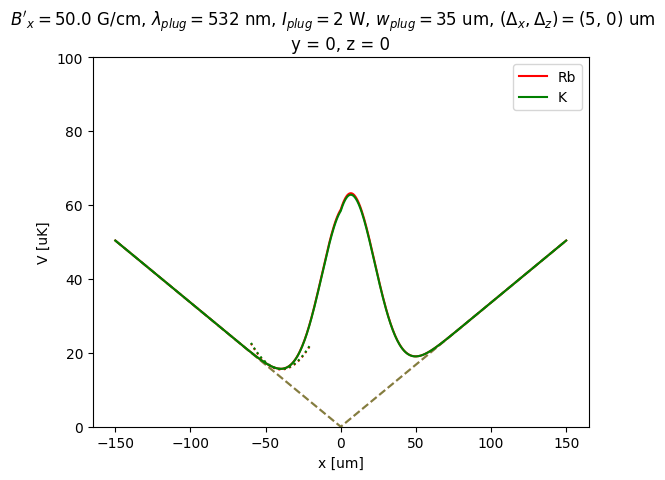

In [147]:
# Create traces for the effective harmonic oscillator
arg_ho_pm = int(20e-6 // spatial_resolution)  # The range within which the harmonic oscillator potential is drawn
Vmin_y0z0_arg_Rb, x_near_Vmin_y0z0_Rb, V_uK_Rb_ho_y0z0 = make_ho_traces(arg_ho_pm,
                                                                        x_range_trap,
                                                                        x_Vmin_Rb,
                                                                        E9c.m_Rb87,
                                                                        w_PQx_Rb,
                                                                        V_uK_Rb_tot_xz)
Vmin_y0z0_arg_K, x_near_Vmin_y0z0_K, V_uK_K_ho_y0z0 = make_ho_traces(arg_ho_pm,
                                                                     x_range_trap,
                                                                     x_Vmin_K,
                                                                     E9c.m_K40,
                                                                     w_PQx_K,
                                                                     V_uK_K_tot_xz)

# Plot
fig_y0z0cut, ax_y0z0cut = plt.subplots(1, 1)
x_range_um = x_range_trap * 1e6
ax_y0z0cut.plot(x_range_um, V_uK_Rb_tot_xz[z0_index], color = Rb_plot_color, label = "Rb")
ax_y0z0cut.plot(x_range_um, V_uK_Rb_B_xz[z0_index], ls = "--", color = Rb_plot_color, alpha = 0.5)
ax_y0z0cut.plot(x_near_Vmin_y0z0_Rb * 1e6, V_uK_Rb_ho_y0z0, ls = ":", color = Rb_plot_color)
ax_y0z0cut.plot(x_range_um, V_uK_K_tot_xz[z0_index], color = K_plot_color, label = "K")
ax_y0z0cut.plot(x_range_um, V_uK_K_B_xz[z0_index], ls = "--", color = K_plot_color, alpha = 0.5)
ax_y0z0cut.plot(x_near_Vmin_y0z0_K * 1e6, V_uK_K_ho_y0z0, ls = ":", color = K_plot_color)
ax_y0z0cut.set_ylim([0, 100])
ax_y0z0cut.set_xlabel("x [um]")
ax_y0z0cut.set_ylabel("V [uK]")
ax_y0z0cut.legend()
ax_y0z0cut.set_title("y = 0, z = 0")
fig_y0z0cut.suptitle(fig_title_trap_params)

Text(0.5, 0.98, "$B'_x =$50.0 G/cm, $\\lambda_{plug} =$532 nm, $I_{plug} =$2 W, $w_{plug} = $35 um, $(\\Delta_x, \\Delta_z) =$(5, 0) um")

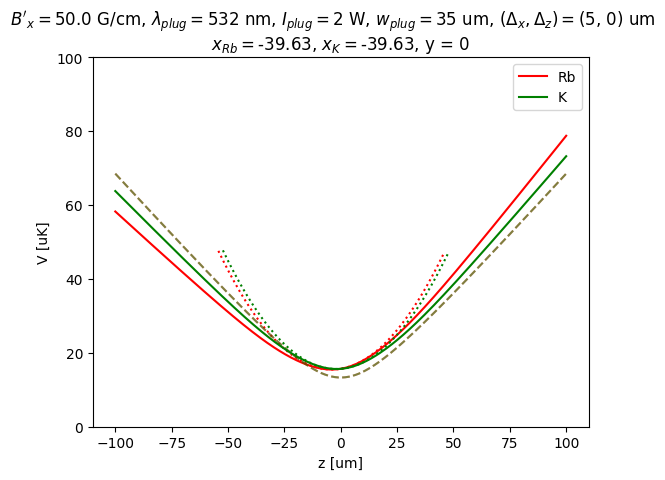

In [148]:
# Create traces for the effective harmonic oscillator
arg_ho_pm = int(50e-6 // spatial_resolution)  # The range within which the harmonic oscillator potential is drawn
Vmin_x0y0_arg_Rb, z_near_Vmin_x0y0_Rb, V_uK_Rb_ho_x0y0 = make_ho_traces(arg_ho_pm,
                                                                        z_range_trap,
                                                                        z_Vmin_Rb,
                                                                        E9c.m_Rb87,
                                                                        w_PQz_Rb,
                                                                        V_uK_Rb_tot_xz)
Vmin_x0y0_arg_K, z_near_Vmin_x0y0_K, V_uK_K_ho_x0y0 = make_ho_traces(arg_ho_pm,
                                                                     z_range_trap,
                                                                     z_Vmin_K,
                                                                     E9c.m_K40,
                                                                     w_PQz_K,
                                                                     V_uK_K_tot_xz)

# Plot
fig_x0y0cut, ax_x0y0cut = plt.subplots(1, 1)
z_range_um = z_range_trap * 1e6
x_Vmin_axis1_arg_Rb = np.argwhere(xx_xz[0, :] == x_Vmin_Rb)[0][0]
x_Vmin_axis1_arg_K = np.argwhere(xx_xz[0, :] == x_Vmin_K)[0][0]
ax_x0y0cut.plot(z_range_um, V_uK_Rb_tot_xz[:, x_Vmin_axis1_arg_Rb], color = Rb_plot_color, label = "Rb")
ax_x0y0cut.plot(z_range_um, V_uK_Rb_B_xz[:, x_Vmin_axis1_arg_Rb], ls = "--", color = Rb_plot_color, alpha = 0.5)
ax_x0y0cut.plot(z_near_Vmin_x0y0_Rb * 1e6, V_uK_Rb_ho_x0y0, ls = ":", color = Rb_plot_color)
ax_x0y0cut.plot(z_range_um, V_uK_K_tot_xz[:, x_Vmin_axis1_arg_K], color = K_plot_color, label = "K")
ax_x0y0cut.plot(z_range_um, V_uK_K_B_xz[:, x_Vmin_axis1_arg_K], ls = "--", color = K_plot_color, alpha = 0.5)
ax_x0y0cut.plot(z_near_Vmin_x0y0_K * 1e6, V_uK_K_ho_x0y0, ls = ":", color = K_plot_color)
ax_x0y0cut.set_ylim([0, 100])
ax_x0y0cut.set_xlabel("z [um]")
ax_x0y0cut.set_ylabel("V [uK]")
ax_x0y0cut.legend()
ax_x0y0cut.set_title(r"$x_{Rb} =$" + f"{x_Vmin_Rb * 1e6:.2f}, " + r"$x_{K} =$" + f"{x_Vmin_K * 1e6:.2f}, y = 0")
fig_x0y0cut.suptitle(fig_title_trap_params)

### 2D cuts

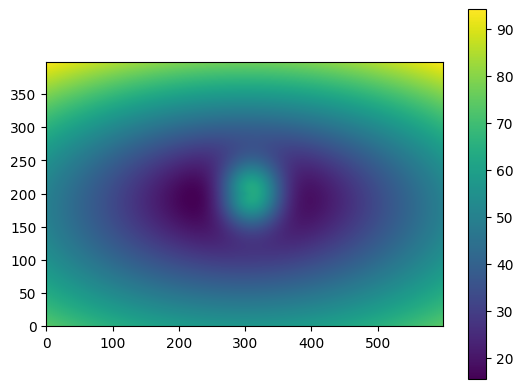

In [149]:
plt.imshow(V_uK_Rb_tot_xz, vmin = V_uK_Rb_tot_xz.min(), vmax = V_uK_Rb_tot_xz.max(), origin = "lower")
plt.colorbar()

# Rate calculations (losses, collisions etc.)
Trap parameters are the ones used in the calculations above
1. For each of the item below, rates are listed for different atom number and temperature combinations, with the following assumptions:
    1. The system is in thermal equilibrium.
        * Trap depth is not a parameter here, but practically we need to assume something like $\eta = 10$ to determine temperature from trap depth. (And for rf evaporation, the trap depth for Rb is 2/3 of the rf knife detuning)
    1. The trap potential is well approximated by a harmonic confinement (, taking spatial displacement into consideration).
    1. Both species are **deep in the thermal regime**, i.e. they obey Boltzman statistics.
    1. The density of atoms are **not affected by interaction**. *TODO*: but they must be - this is valid if the mean field energy if interaction is small compared to k_B * T (I guess)
1. Values are calculated at the position of maximum overlap. *TODO*: maybe extend this to an integral over the whole sample?
1. Rates without the plug beam also included for reference.

## Inputs

In [150]:
dim_N_Rb = 100
dim_N_K = 50
dim_T = 20
T_range = np.logspace(0, 1.5, dim_T) * 1e-6     # Temperature of the gas, assuming thermal equilibrium
T_uK_range = T_range * 1e6                      # Temperature in uK (for plotting)
T_selected_index = np.arange(0, dim_T, 5)       # Index of the temperatures looked at for selected plots

## Cloud sizes and densities
Note that the cloud sizes for plugged traps are approximated by the effective trap frequencies, and are very wrong except for the lowest temperatures (since the atoms see non-harmonic part of the trap)

The exact cloud shape can calculated numerically using $n(\vec{r}) \propto \exp{[-V(\vec{r}) / k_B T]}$, but it also requires the full 3D potential in order to get the correct normalization. Will say that it is not necessary for now.

In [151]:
# Thermal cloud sizes at temperatures in T_range
rxy_Rb_unplugged = E9ct.r0_thermal_lin(B_grad_xy * mu_Rb, T_range) * 0.9    # Same for x and y in a quadrupole trap; 0.9 is a fudge factor, see docstring of r0_thermal_lin
rgavg_Rb_unplugged = rxy_Rb_unplugged * 2**(1/3)
rxy_K_unplugged = E9ct.r0_thermal_lin(B_grad_xy * mu_K, T_range) * 0.9
rgavg_K_unplugged = rxy_K_unplugged * 2**(1/3)

rx_Rb_plugged = E9ct.r0_thermal_har(w_PQx_Rb, T_range, E9c.m_Rb87)
ry_Rb_plugged = E9ct.r0_thermal_har(w_PQy_Rb, T_range, E9c.m_Rb87)
rz_Rb_plugged = E9ct.r0_thermal_har(w_PQz_Rb, T_range, E9c.m_Rb87)
rgavg_Rb_plugged = (rx_Rb_plugged * ry_Rb_plugged * rz_Rb_plugged)**(1 / 3)
rx_K_plugged = E9ct.r0_thermal_har(w_PQx_K, T_range, E9c.m_Rb87)
ry_K_plugged = E9ct.r0_thermal_har(w_PQy_K, T_range, E9c.m_Rb87)
rz_K_plugged = E9ct.r0_thermal_har(w_PQz_K, T_range, E9c.m_Rb87)
rgavg_K_plugged = (rx_K_plugged * ry_K_plugged * rz_K_plugged)**(1 / 3)

In [152]:
# Maximum cloud densities for a specific atom number
N_Rb = 3e7
N_K = 2.5e5
nmax_Rb_unplugged = E9ct.n_peak_lin(N_Rb, B_grad_xy * mu_Rb, T_range)
nmax_Rb_plugged = E9ct.n_peak_har(N_Rb, wbar_PQ_Rb, T_range, E9c.m_Rb87)
nmax_K_unplugged = E9ct.n_peak_lin(N_K, B_grad_xy * mu_K, T_range)
nmax_K_plugged = E9ct.n_peak_har(N_K, wbar_PQ_K, T_range, E9c.m_K40)

(10000000000.0, 1e+16)

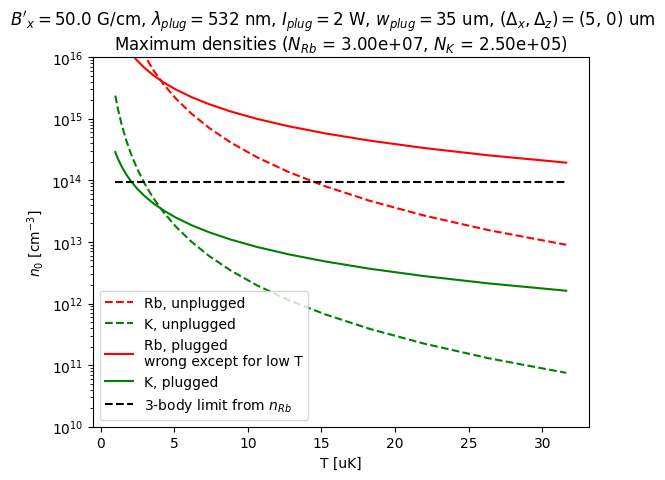

In [153]:
# Plot the thermal cloud densities as a function of temperature (radii plotted in the Majorana section)
fig_nmax, ax_nmax = plt.subplots(1, 1)
ax_nmax.semilogy(T_uK_range, nmax_Rb_unplugged * 1e-6, ls = "--", color = Rb_plot_color, label = "Rb, unplugged")
ax_nmax.semilogy(T_uK_range, nmax_K_unplugged * 1e-6, ls = "--", color = K_plot_color, label = "K, unplugged")
ax_nmax.semilogy(T_uK_range, nmax_Rb_plugged * 1e-6, color = Rb_plot_color, label = "Rb, plugged\nwrong except for low T")
ax_nmax.semilogy(T_uK_range, nmax_K_plugged * 1e-6, color = K_plot_color, label = "K, plugged")
ax_nmax.hlines(1e-6 / np.sqrt(E9c.G3loss_Rb87_F2mF2), T_uK_range[0], T_uK_range[-1], ls = "--", color = "black", label = "3-body limit from " + r"$n_{Rb}$")
ax_nmax.legend()
ax_nmax.set_title(r"Maximum densities ($N_{Rb}$ = " + f"{N_Rb:.2e}, " + r"$N_{K}$ = " + f"{N_K:.2e})")
ax_nmax.set_xlabel("T [uK]")
ax_nmax.set_ylabel(r"$n_0$ [cm$^{-3}$]")
fig_nmax.suptitle(fig_title_trap_params)
ax_nmax.set_ylim([1e10, 1e16])

In [154]:
# Density of the thermal cloud calculated using the exact potential
# They have the dimensions of (dim_x, dim_y, dim_z, dim_T), and will need to be multiplied by N_atoms
# Disabled by default since this is a lot of points
if 0:
    V_Rb_tot_xyz = None
    density_Rb_plugged = E9ct.n_thermal_norm1_from_V(V_uK_Rb_tot_xz[:, :, :, np.newaxis],
                                                     T_range[np.newaxis, np.newaxis, np.newaxis, :] * 1e6) / V_voxel

## Majorana losses and depolarization
This is only calculated for unplugged trap; for plugged trap, check that the loss radius is smaller than the trap minimum when the temperature is low
* Only look at lower temperatures
* Loss rates $\gamma \propto B'^2$ and loss radius $r \propto B'^{-\frac{1}{2}}$ are both calculated with the **geometric mean** of gradient, i.e. $2^{\frac{1}{3}} B'_x$

In [155]:
r_safety_factor = 10    # an arbitrary factor multiplied to the loss radii, since they are just order of magnitude approximations
B_grad_gm = 2**(1/3) * B_grad_xy
gamma_majorana_Rb = E9ct.majorana_loss_rate(Rb_atom, B_grad_gm, T_range)
r_majorana_Rb = E9ct.majorana_loss_radius(Rb_atom, B_grad_gm, T_range) * r_safety_factor
gamma_majorana_K = E9ct.majorana_loss_rate(K_atom, B_grad_gm, T_range)
r_majorana_K = E9ct.majorana_loss_radius(K_atom, B_grad_gm, T_range) * r_safety_factor

Say unplugged trap becomes very lossy when the loss radius is the same as the cloud size (K always gives a larger value). This value is not dependent on the plug beam and can be used to guess the lowest waist needed.

Alternatively, we might be good if the atoms are displaced enough that most of the atom don't go into the radius. In this case Rb might the limiting factor due to its lower effective trap frequency, and therefore the larger cloud size.

In [156]:
r_K_abs_diff = abs(rgavg_K_unplugged - r_majorana_K)
arg_must_plug = r_K_abs_diff.argmin()
r_must_plug = r_majorana_K[arg_must_plug]
T_must_plug = T_range[arg_must_plug]

print(f"Safe bet: the plug beam should at least have a waist of {r_must_plug * 1e6:.1f} um, if we evaporate down to {T_must_plug * 1e6:.1f} uK")
if r_must_plug > w0_plug:
    print(f"Current plug waist {w0_plug * 1e6:.1f} um is smaller than this!")
    r_margin_with_plug_Rb = -abs(x_Vmin_Rb) + rgavg_Rb_plugged - r_must_plug
    T_loss_with_plug_Rb = T_range[np.argmax(r_margin_with_plug_Rb > 0)]
    r_margin_with_plug_K = -abs(x_Vmin_K) + rgavg_K_plugged - r_must_plug
    T_loss_with_plug_K = T_range[np.argmax(r_margin_with_plug_K > 0)]

    if T_loss_with_plug_Rb > T_range[0] or T_loss_with_plug_K > T_range[0]:
        print("Still bad! Evaporation might be lossy until")
        if T_loss_with_plug_Rb > T_range[0]:
            print(f"    {T_loss_with_plug_Rb * 1e6:.1f} uK (limited by Rb)")
        if T_loss_with_plug_K > T_range[0]:
            print(f"    {T_loss_with_plug_K * 1e6:.1f} uK (limited by K)")
        print("(lower is worse, i.e. lossy for a larger temperature interval)")
    else:
        print("But the beam seems to push the atoms far enough away")

Safe bet: the plug beam should at least have a waist of 37.2 um, if we evaporate down to 10.6 uK
Current plug waist 35.0 um is smaller than this!
But the beam seems to push the atoms far enough away


Note that the cloud size is the harmonic oscillator length for plugged traps, and 1/e length for liner traps

Text(0.5, 0.98, "$B'_x =$50.0 G/cm, $\\lambda_{plug} =$532 nm, $I_{plug} =$2 W, $w_{plug} = $35 um, $(\\Delta_x, \\Delta_z) =$(5, 0) um")

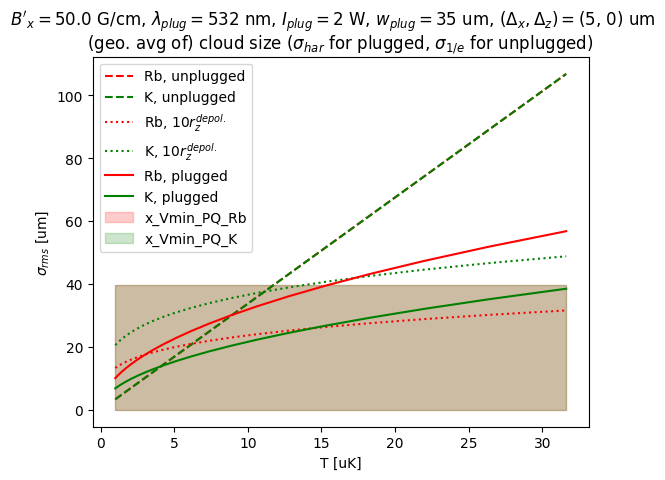

In [157]:
fig_rgavg, ax_rgavg = plt.subplots(1, 1)
ax_rgavg.plot(T_uK_range, rgavg_Rb_unplugged * 1e6, ls = "--", color = Rb_plot_color, label = "Rb, unplugged")
ax_rgavg.plot(T_uK_range, rgavg_K_unplugged * 1e6, ls = "--", color = K_plot_color, label = "K, unplugged")
ax_rgavg.plot(T_uK_range, r_majorana_Rb * 1e6, ls = ":", color = Rb_plot_color, label = f"Rb, {r_safety_factor}" + r"$r^{depol.}_z$")
ax_rgavg.plot(T_uK_range, r_majorana_K * 1e6, ls = ":", color = K_plot_color, label = f"K, {r_safety_factor}" + r"$r^{depol.}_z$")
ax_rgavg.plot(T_uK_range, rgavg_Rb_plugged * 1e6, color = Rb_plot_color, label = "Rb, plugged")
ax_rgavg.plot(T_uK_range, rgavg_K_plugged * 1e6, color = K_plot_color, label = "K, plugged")
ax_rgavg.fill_between(T_uK_range, abs(x_Vmin_Rb) * 1e6, color = Rb_plot_color, alpha = 0.2, label = "x_Vmin_PQ_Rb")
ax_rgavg.fill_between(T_uK_range, abs(x_Vmin_K) * 1e6, color = K_plot_color, alpha = 0.2, label = "x_Vmin_PQ_K")
ax_rgavg.legend()
ax_rgavg.set_title(r"(geo. avg of) cloud size ($\sigma_{har}$ for plugged, $\sigma_{1/e}$ for unplugged)")
ax_rgavg.set_xlabel("T [uK]")
ax_rgavg.set_ylabel(r"$\sigma_{rms}$ [um]")
fig_rgavg.suptitle(fig_title_trap_params)
# ax_rgavg.set_ylim([0, 60])

Text(0.5, 0.98, "$B'_x =$50.0 G/cm, $\\lambda_{plug} =$532 nm, $I_{plug} =$2 W, $w_{plug} = $35 um, $(\\Delta_x, \\Delta_z) =$(5, 0) um")

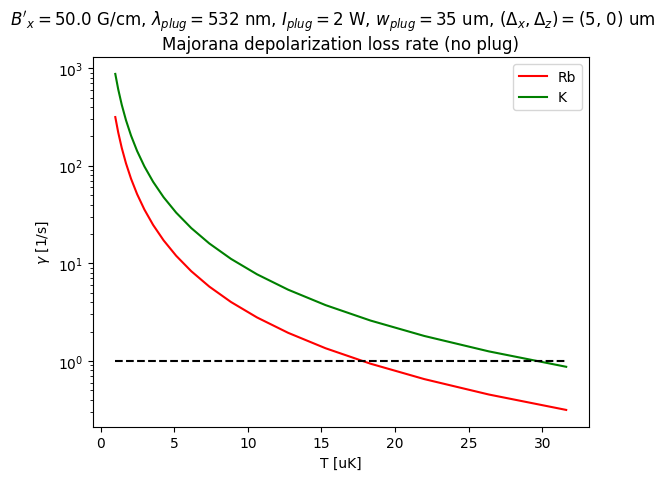

In [158]:
fig_maj_loss, ax_maj_loss = plt.subplots(1, 1)
ax_maj_loss.semilogy(T_uK_range, gamma_majorana_Rb, color = Rb_plot_color, label = "Rb")
ax_maj_loss.semilogy(T_uK_range, gamma_majorana_K, color = K_plot_color, label = "K")
ax_maj_loss.hlines(1, T_uK_range[0], T_uK_range[-1], ls = "--", color = "black")
ax_maj_loss.legend()
ax_maj_loss.set_title("Majorana depolarization loss rate (no plug)")
ax_maj_loss.set_xlabel("T [uK]")
ax_maj_loss.set_ylabel(r"$\gamma$ [1/s]")
fig_maj_loss.suptitle(fig_title_trap_params)

## Elastic collision rate

In general high is good, but if the density is too high, three-body loss can eventually make this unfavourable, as it scales faster with density. The figure of merit can be identified as 

$\xi(\vec{r}; T) = \Large\frac{\Gamma_{el}}{\Gamma_3} = \Large\frac{v_{rms}(T) \sigma_{sc}(T)}{n_{Rb}(\vec{r};\ T) K_3}$

where I
* Ignored background losses
* Used thermal velocity $v_{rms}$ to approximate the elastic collision rate
* assume that I will eventually integrate over all space, so the $\vec{r}$ dependence really only contribute to a scaling factor at the end.

For Rb, both the nominator and denominator have two terms (from collisions with K).

In [159]:
N_range_Rb = np.logspace(6, 8, dim_N_Rb)        # Number of Rb atoms to look at
N_range_K = np.logspace(4.7, 6.3, dim_N_K)      # Number of K atoms to look at
# gamma_elastic_Rb = E9ct.collision_rate()

## Three-body loss rate
The loss rate is given by $\Gamma_3 = K_3 n^3(\vec{x})$. We care about the life time of atoms, so will need to divide by the number of atoms. This results in different scaling laws even if the loss rate is the same: (B for bosonic Rb, F for fermionic K)
* Rb: $\Gamma_3^{tot} \propto K_3^{BBF} N_{Rb} N_K + K_3^{BBB} N_{Rb}^2$
* K: $\Gamma_3^{tot} \propto K_3^{BBF} N_{Rb}^2$

Note that a gaussian squared is still a gaussian, whose waist is $\sigma' = \sigma_0 / \sqrt{2}$

For two clouds with Gaussian shapes, the average loss rate is porportional to and lower than the maximum loss rate.

This is not calculated for unplugged trap (yet), since Majorana loss is bad when three-body loss matters, but I expect the three-body loss is also worse there given the higher density.

In [160]:
# Rb-Rb-K (BBF) losses
# Position of maximum BBF loss - they have length = dim_T, since cloud size varies with T 
x_max_BBF_loss_plugged = util.two_gaussian_1D_max_product(rx_Rb_plugged / np.sqrt(2), rx_K_plugged, x_Vmin_offset)
y_max_BBF_loss_plugged = util.two_gaussian_1D_max_product(ry_Rb_plugged / np.sqrt(2), ry_K_plugged, y_Vmin_offset)
z_max_BBF_loss_plugged = util.two_gaussian_1D_max_product(rz_Rb_plugged / np.sqrt(2), rz_K_plugged, z_Vmin_offset)

overlap_BBF =   util.two_gaussian_1D_power_integral(rx_Rb_plugged, rx_K_plugged, x_Vmin_offset, 2, 1) \
              * util.two_gaussian_1D_power_integral(ry_Rb_plugged, ry_K_plugged, y_Vmin_offset, 2, 1) \
              * util.two_gaussian_1D_power_integral(rz_Rb_plugged, rz_K_plugged, z_Vmin_offset, 2, 1)
gamma_BBF_loss_plugged_total_N1 = E9c.G3loss_Rb87_K40 * overlap_BBF   # "N_Rb = N_K = 1" loss rate
# The BBF losses below are 3d-arrays of dimensions (dim_N_Rb, dim_N_K, dim_T)
# Each of them are loss rate per atom, so the values are already divided by the atom number of species of interest
# (, which is done by changing the powers of each elements below; **1 and **0 kept for readability. See scaling above)
gamma_BBF_loss_plugged_Rb = np.einsum("i,j,k->ijk", N_range_Rb**1, N_range_K**1, gamma_BBF_loss_plugged_total_N1)
gamma_BBF_loss_plugged_K = np.einsum("i,j,k->ijk", N_range_Rb**2, N_range_K**0, gamma_BBF_loss_plugged_total_N1)

# Rb-Rb-Rb (BBB) losses
# For Rb three body loss (BBB), the position of maximum loss is at the trap minimum
# BBB loss for Rb is a 2d-array of dimensions (dim_N_Rb, dim_T)
overlap_BBB =   util.two_gaussian_1D_power_integral(rx_Rb_plugged, rx_Rb_plugged, 0, 2, 1) \
              * util.two_gaussian_1D_power_integral(ry_Rb_plugged, ry_Rb_plugged, 0, 2, 1) \
              * util.two_gaussian_1D_power_integral(rz_Rb_plugged, rz_Rb_plugged, 0, 2, 1)
gamma_BBB_loss_plugged_Rb = E9c.G3loss_Rb87_F2mF2 * np.outer(N_range_Rb**2, overlap_BBB)

# Rb total three-body losses
gamma_3bd_loss_plugged_Rb = gamma_BBF_loss_plugged_Rb + gamma_BBB_loss_plugged_Rb[:, np.newaxis, :]

Text(0.5, 0.98, "$B'_x =$50.0 G/cm, $\\lambda_{plug} =$532 nm, $I_{plug} =$2 W, $w_{plug} = $35 um, $(\\Delta_x, \\Delta_z) =$(5, 0) um\n$N_K$ =1.0e+06 - I don't know how to present the 2D data yet")

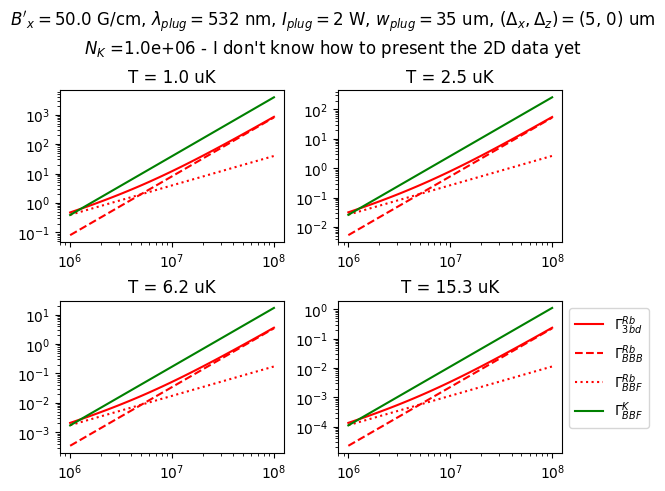

In [161]:
# Only plot for the selected temperatures for now
n_rows_3bd_loss = int(np.floor(np.sqrt(len(T_selected_index))))
n_col_3bd_loss = int(np.ceil(len(T_selected_index) / n_rows_3bd_loss))
fig_3bd, ax_3bd_list = plt.subplots(n_rows_3bd_loss, n_col_3bd_loss, layout = "constrained")
iK = -10
for i, iT in enumerate(T_selected_index):
    T = T_range[iT]
    ax_3bd = ax_3bd_list.flatten()[i]
    ax_3bd.loglog(N_range_Rb, gamma_3bd_loss_plugged_Rb[:,iK,iT], color = Rb_plot_color, ls = "-", label = r"$\Gamma_{3bd}^{Rb}$")
    ax_3bd.loglog(N_range_Rb, gamma_BBB_loss_plugged_Rb[:,iT], color = Rb_plot_color, ls = "--", label = r"$\Gamma_{BBB}^{Rb}$")
    ax_3bd.loglog(N_range_Rb, gamma_BBF_loss_plugged_Rb[:,iK,iT], color = Rb_plot_color, ls = ":", label = r"$\Gamma_{BBF}^{Rb}$")
    ax_3bd.loglog(N_range_Rb, gamma_BBF_loss_plugged_K[:,iK,iT], color = K_plot_color, label = r"$\Gamma_{BBF}^{K}$")
    ax_3bd.set_title(f"T = {T * 1e6:.1f} uK")
ax_3bd.legend(bbox_to_anchor = (1, 1))
fig_3bd.suptitle(fig_title_trap_params + "\n"
                 + r"$N_K$ =" + f"{N_range_K[iK]:.1e} - I don't know how to present the 2D data yet")

## Photon scattering rate
Doesn't seem too important now that we have decided to not use very near detuned light

In [162]:
a = 1 / (2 * np.sqrt(3) * np.pi)
b = util.two_gaussian_1D_power_integral(1,1,0,1,1)
c = util.two_gaussian_1D_power_integral(1e-5,1e-5,0,1,1)
print(a)
print(b)
print(a/b)
print(c)

0.09188814923696535
0.28209479177387814
0.32573500793528
28209.479177387813
